I. DATA COLLECTION AND PREPARATION 

A. Use the TroPyCal Python library to obtain the information through the inbuilt API.

In [180]:
!pip install tropycal

Defaulting to user installation because normal site-packages is not writeable


In [181]:
import tropycal

B. Survey the list of 25 cities provided. Mark their latitude/longitude.

Used https://www.latlong.net/ to find latitude/longitude values.

In [182]:
import pandas as pd
import numpy as np

In [183]:
dataFrame = pd.read_csv(r"C:\Users\b1ane\iCloudDrive\Classes\(3337) Data Science I\Tasks\Group Task 3\gulf-cities.csv")

In [184]:
dataFrame.head()

City Name Country
0     New Orleans     USA
1         Houston     USA
2           Tampa     USA
3           Miami     USA
4  Corpus Christi     USA

In [185]:
lat_long = {
    "New Orleans": (29.9511, -90.0715),
    "Houston": (29.7604, -95.3698),
    "Tampa": (27.9506, -82.4572),
    "Miami": (25.7617, -80.1918),
    "Corpus Christi": (27.8006, -97.3964),
    "Pensacola": (30.4213, -87.2169),
    "Mobile": (30.6954, -88.0399),
    "Galveston": (29.3013, -94.7977),
    "Biloxi": (30.3960, -88.8853),
    "Key West": (24.5551, -81.7800),
    "Veracruz": (19.1738, -96.1342),
    "Tampico": (22.2333, -97.8614),
    "Campeche": (19.8458, -90.5252),
    "Cancún": (21.1619, -86.8515),
    "Mérida": (20.9674, -89.5926),
    "Ciudad del Carmen": (18.6435, -91.8330),
    "Progreso": (21.2837, -89.6482),
    "Coatzacoalcos": (18.1494, -94.4200),
    "Tuxpan": (20.9580, -97.4083),
    "Havana": (23.1136, -82.3666),
    "Varadero": (23.1510, -81.2453),
    "Cienfuegos": (22.1492, -80.4417),
    "Belize City": (17.5046, -88.1934),
    "George Town": (19.2869, -81.2546),
    "Nassau": (25.0343, -77.3963)
}

In [186]:
latitudes = []
longitudes = []

for city in dataFrame['City Name']:
    # Check if the city is in the dictionary
    if city in lat_long:
        lat, long = lat_long[city]
    latitudes.append(lat)
    longitudes.append(long)

dataFrame['Latitude'] = latitudes
dataFrame['Longitude'] = longitudes

In [187]:
dataFrame.head()

City Name Country  Latitude  Longitude
0     New Orleans     USA   29.9511   -90.0715
1         Houston     USA   29.7604   -95.3698
2           Tampa     USA   27.9506   -82.4572
3           Miami     USA   25.7617   -80.1918
4  Corpus Christi     USA   27.8006   -97.3964

In [188]:
!pip install shapely

Defaulting to user installation because normal site-packages is not writeable


In [189]:
!pip install cartopy

Defaulting to user installation because normal site-packages is not writeable


In [190]:
from geopy.distance import geodesic

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (2.25 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (5.17 seconds)


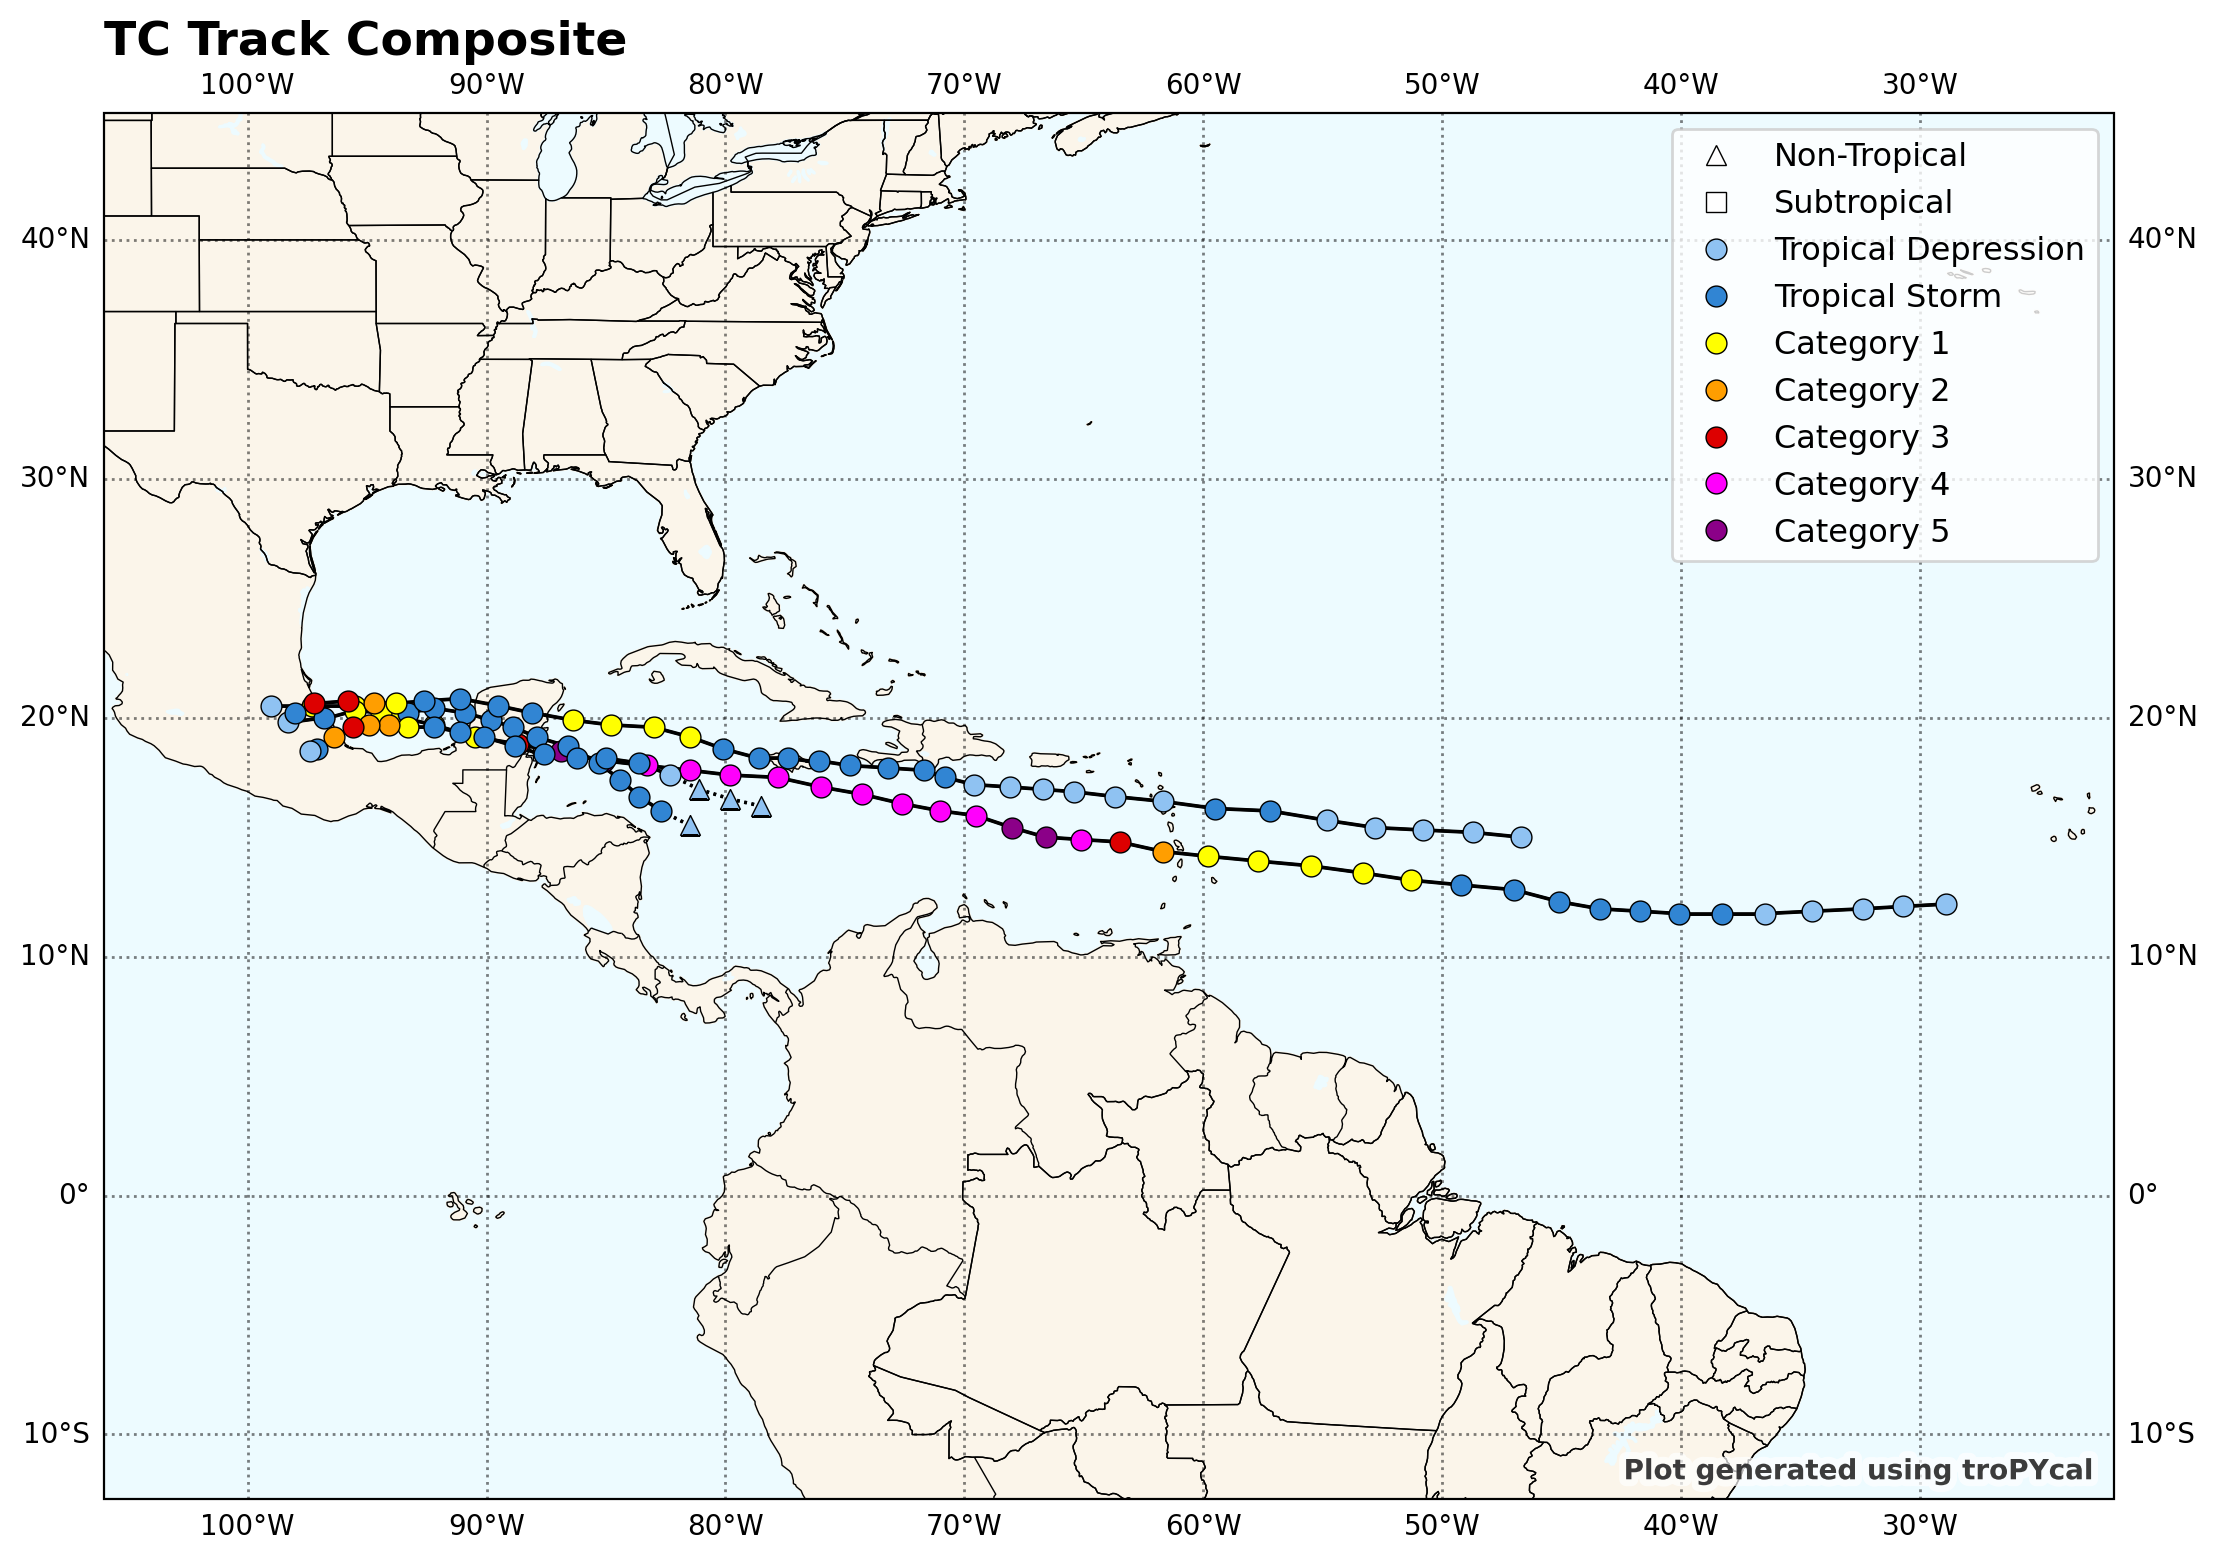

In [192]:
from tropycal import tracks, utils, rain
basin = tracks.TrackDataset(include_btk=True)

thresh = {'v_min': 73}

veracruz_domain = {
    'north': 21.0, 
    'south': 17.0,
    'west': -98.0,
    'east': -94.0
}

veracruz_storms = basin.filter_storms(
    storm=None,  # Search through all storms 
    year_range=(1999, 2024),
    date_range=None,
    thresh=thresh,
    domain=veracruz_domain,
    interpolate_data=False,
    return_keys=True
)


basin.plot_storms(veracruz_storms)

#Frequency
dataFrame['Frequency'] = 0.0
totalVeracruz = len(veracruz_storms)
dataFrame['Frequency'] = dataFrame['Frequency'].astype(float)
dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Frequency'] = totalVeracruz

#Intensity - maximum wind speed (vmax) and minimum pressure (mslp) 
total_vmax = 0
total_mslp = 0
storm_count = 0

#Motion Vectors - represents speed and direction of storm's movement
speeds = []
directions = []

#loops through each storm to find average vmax & mslp
for storm_key in veracruz_storms:
    storm = basin.get_storm(storm_key)

    #Intensity
    max_wind = max(storm.dict['vmax'])  # Max wind speed (vmax) of the storm
    min_pressure = min([p for p in storm.dict['mslp'] if p is not None])  # Min pressure (mslp) of the storm
    
    #update counters
    total_vmax += max_wind
    total_mslp += min_pressure
    storm_count += 1

    #calculate averages
    avg_vmax = total_vmax / storm_count
    avg_mslp = total_mslp / storm_count

    #Motion Vectors
    for i in range(1, len(storm.dict['lat'])):
        lat1, lon1 = storm.dict['lat'][i - 1], storm.dict['lon'][i - 1]
        lat2, lon2 = storm.dict['lat'][i], storm.dict['lon'][i]
        
        #calculate distance
        distance = geodesic((lat1, lon1), (lat2, lon2)).nautical
        
        #calculate time difference
        time_diff = (storm.dict['time'][i] - storm.dict['time'][i - 1]).total_seconds() / 3600.0  # in hours
        
        #calculate speed 
        if time_diff > 0:
            speed = distance / time_diff
            speeds.append(speed)
            
            #calculate direction
            direction = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1))
            directions.append(direction)

    #Duration
    start_time = storm.dict['time'][0]
    end_time = storm.dict['time'][-1]
    duration_hours = (end_time - start_time).total_seconds() / 3600.0

    durations.append(duration_hours)
    
#calculates average speed and direction
avg_speed = np.mean(speeds) if speeds else 0
avg_direction = np.mean(directions) if directions else 0

avg_duration_hours = np.mean(durations) if durations else 0
avg_duration_days = avg_duration_hours / 24  #convert to days
    
dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Avg Vmax'] = avg_vmax
dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Avg Mslp'] = avg_mslp

dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Avg Speed'] = avg_speed
dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Avg Direction'] = avg_direction

dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Avg Duration (hours)'] = avg_duration_hours
dataFrame.loc[dataFrame['City Name'] == 'Veracruz', 'Avg Duration (days)'] = avg_duration_days

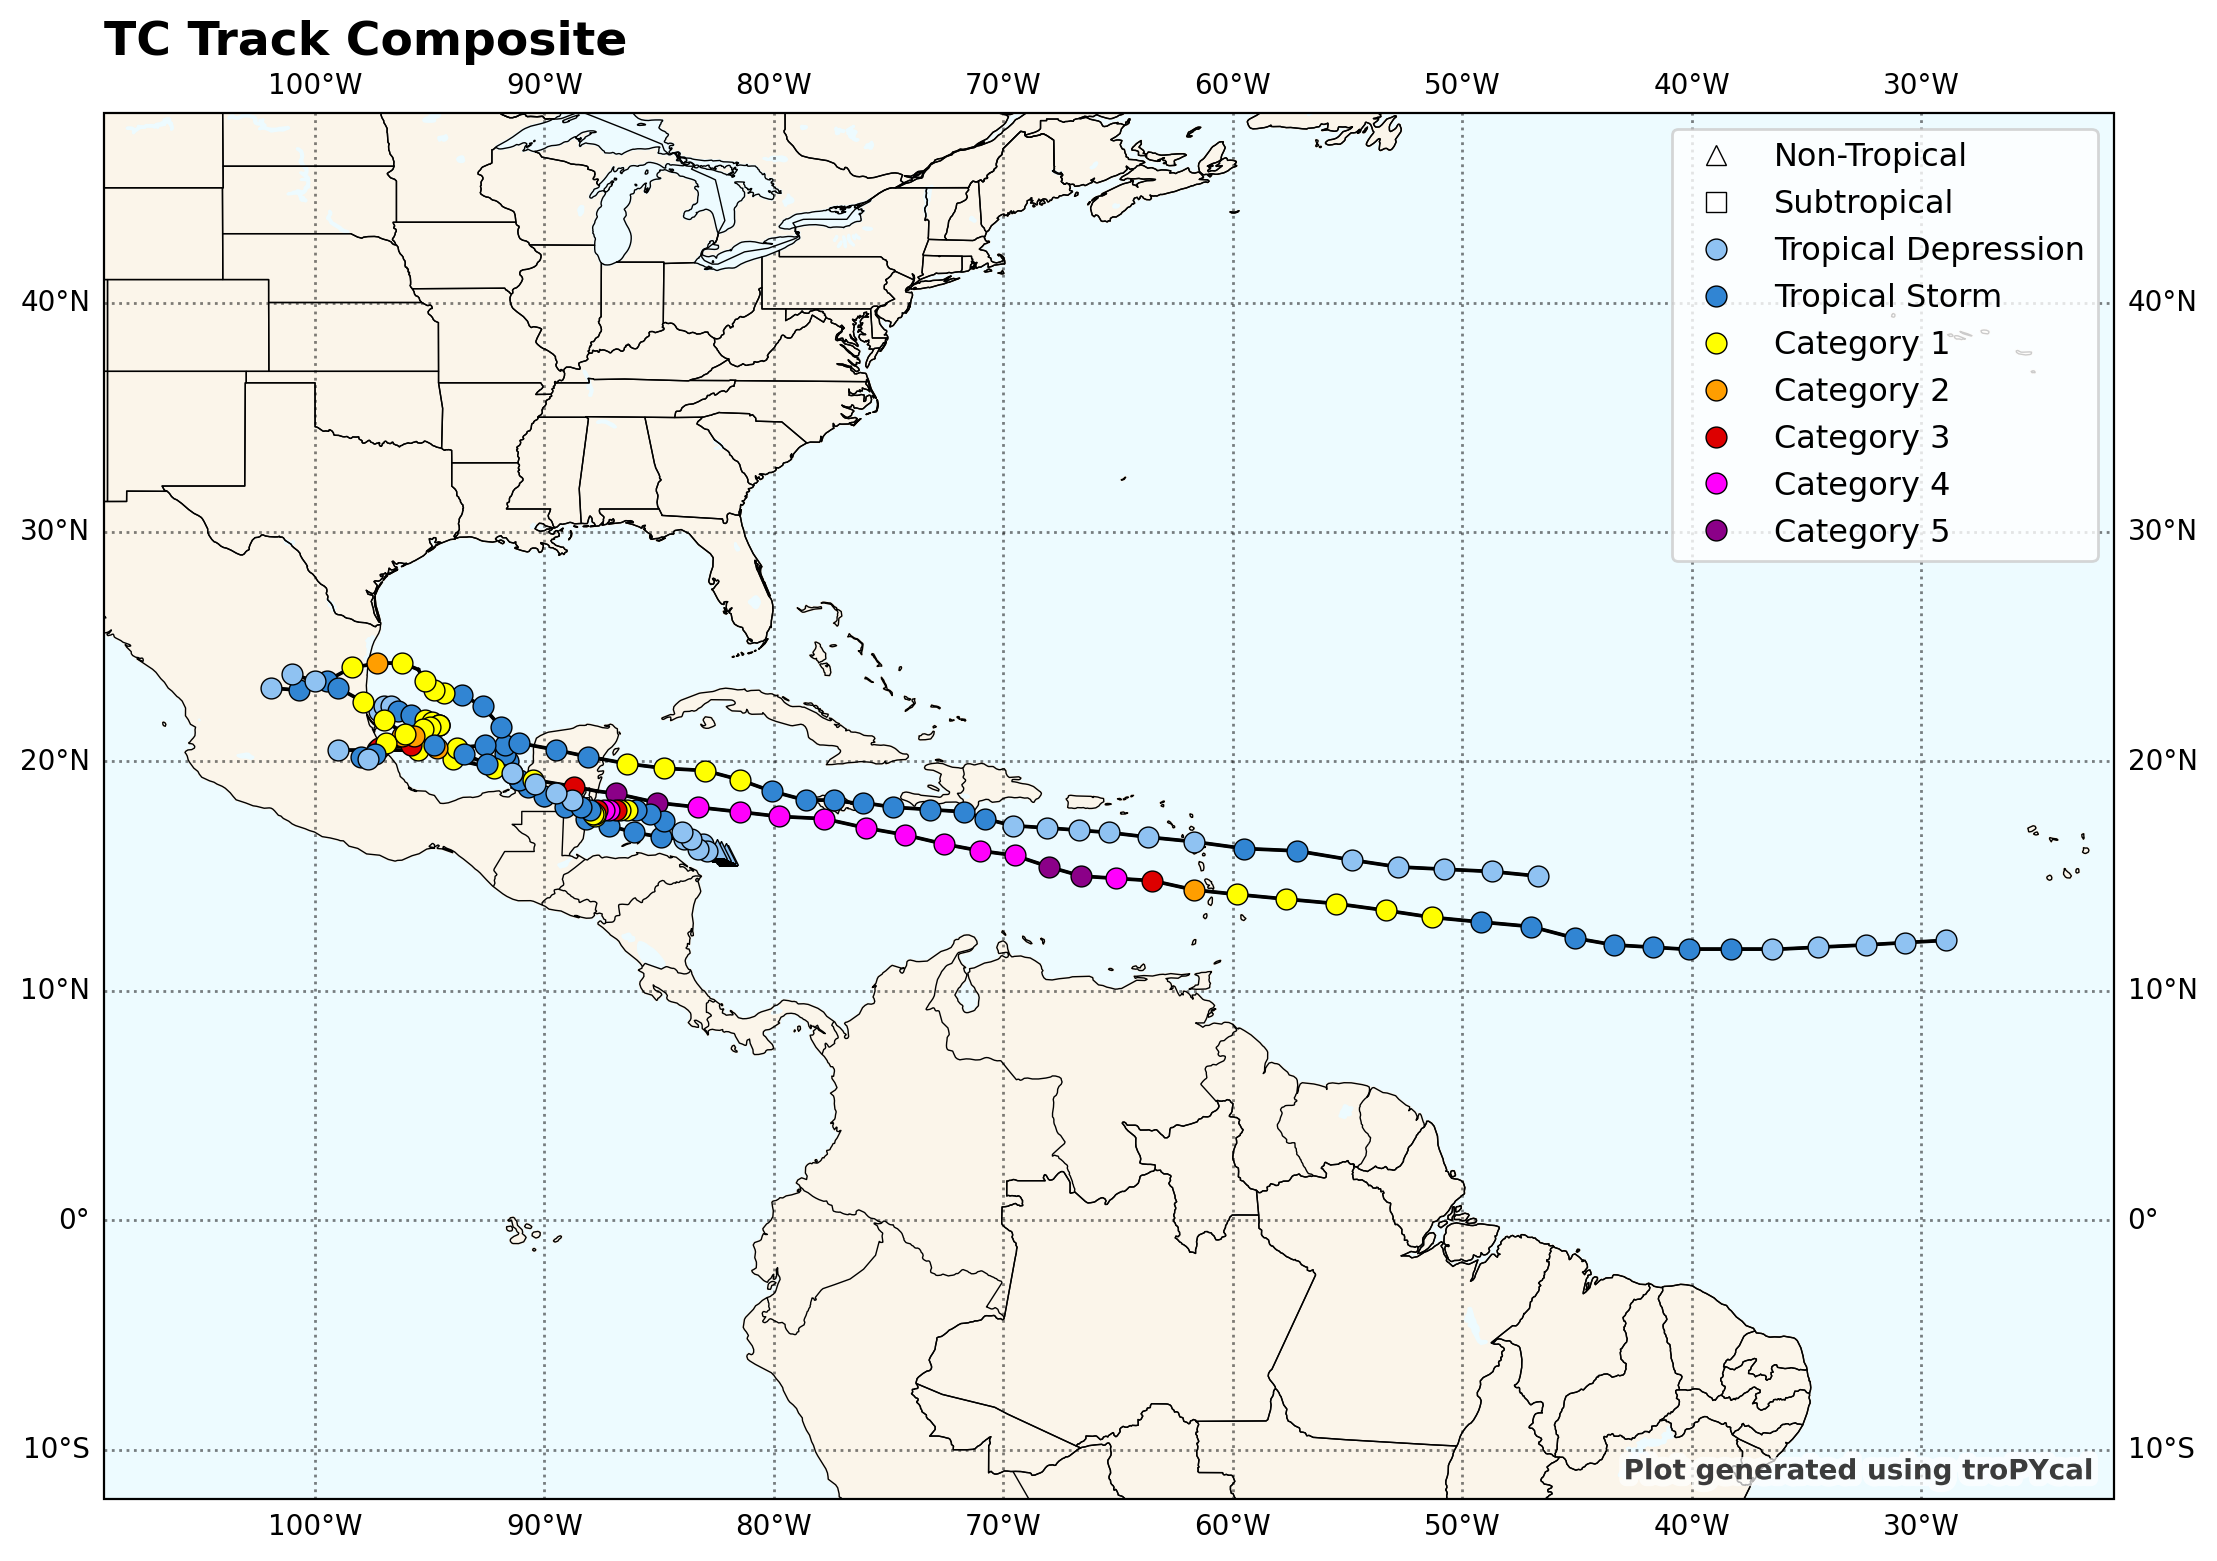

In [193]:
tampico_domain = {
    'north': 24.3, 
    'south': 20.3,
    'west': -99.9,   
    'east': -95.9    
}

tampico_storms = basin.filter_storms(
    storm=None,  # Search through all storms 
    year_range=(1999, 2024),  # Specify year range
    date_range=None,  # Include all dates within years
    thresh=thresh,  # Apply wind threshold 
    domain=tampico_domain,  # Gulf of Mexico domain
    interpolate_data=False,  # Keep original 6-hourly data
    return_keys=True  # Return  keys
)

basin.plot_storms(tampico_storms)

# Frequency
totalTampico = len(tampico_storms)
dataFrame['Frequency'] = dataFrame['Frequency'].astype(float)
dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Frequency'] = totalTampico

# Intensity - maximum wind speed (vmax) and minimum pressure (mslp) 
total_vmax = 0
total_mslp = 0
storm_count = 0

# Motion Vectors - represents speed and direction of storm's movement
speeds = []
directions = []
durations = []  # Initialize durations for Tampico storms

# Loops through each storm to find average vmax & mslp
for storm_key in tampico_storms:
    storm = basin.get_storm(storm_key)

    # Intensity
    max_wind = max(storm.dict['vmax'])  # Max wind speed (vmax) of the storm
    min_pressure = min([p for p in storm.dict['mslp'] if p is not None])  # Min pressure (mslp) of the storm
    
    # Update counters
    total_vmax += max_wind
    total_mslp += min_pressure
    storm_count += 1

# Calculate intensity averages
avg_vmax = total_vmax / storm_count
avg_mslp = total_mslp / storm_count

# Motion Vectors and Duration for each storm
for storm_key in tampico_storms:
    storm = basin.get_storm(storm_key)

    for i in range(1, len(storm.dict['lat'])):
        lat1, lon1 = storm.dict['lat'][i - 1], storm.dict['lon'][i - 1]
        lat2, lon2 = storm.dict['lat'][i], storm.dict['lon'][i]
        
        # Calculate distance
        distance = geodesic((lat1, lon1), (lat2, lon2)).nautical
        
        # Calculate time difference
        time_diff = (storm.dict['time'][i] - storm.dict['time'][i - 1]).total_seconds() / 3600.0  # in hours
        
        # Calculate speed 
        if time_diff > 0:
            speed = distance / time_diff
            speeds.append(speed)
            
            # Calculate direction
            direction = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1))
            directions.append(direction)

    # Duration
    start_time = storm.dict['time'][0]
    end_time = storm.dict['time'][-1]
    duration_hours = (end_time - start_time).total_seconds() / 3600.0
    durations.append(duration_hours)
    
# Calculate average speed, direction, and duration
avg_speed = np.mean(speeds) if speeds else 0
avg_direction = np.mean(directions) if directions else 0

avg_duration_hours = np.mean(durations) if durations else 0
avg_duration_days = avg_duration_hours / 24  # Convert to days

# Store results in the dataFrame for Tampico
dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Avg Vmax'] = avg_vmax
dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Avg Mslp'] = avg_mslp

dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Avg Speed'] = avg_speed
dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Avg Direction'] = avg_direction

dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Avg Duration (hours)'] = avg_duration_hours
dataFrame.loc[dataFrame['City Name'] == 'Tampico', 'Avg Duration (days)'] = avg_duration_days

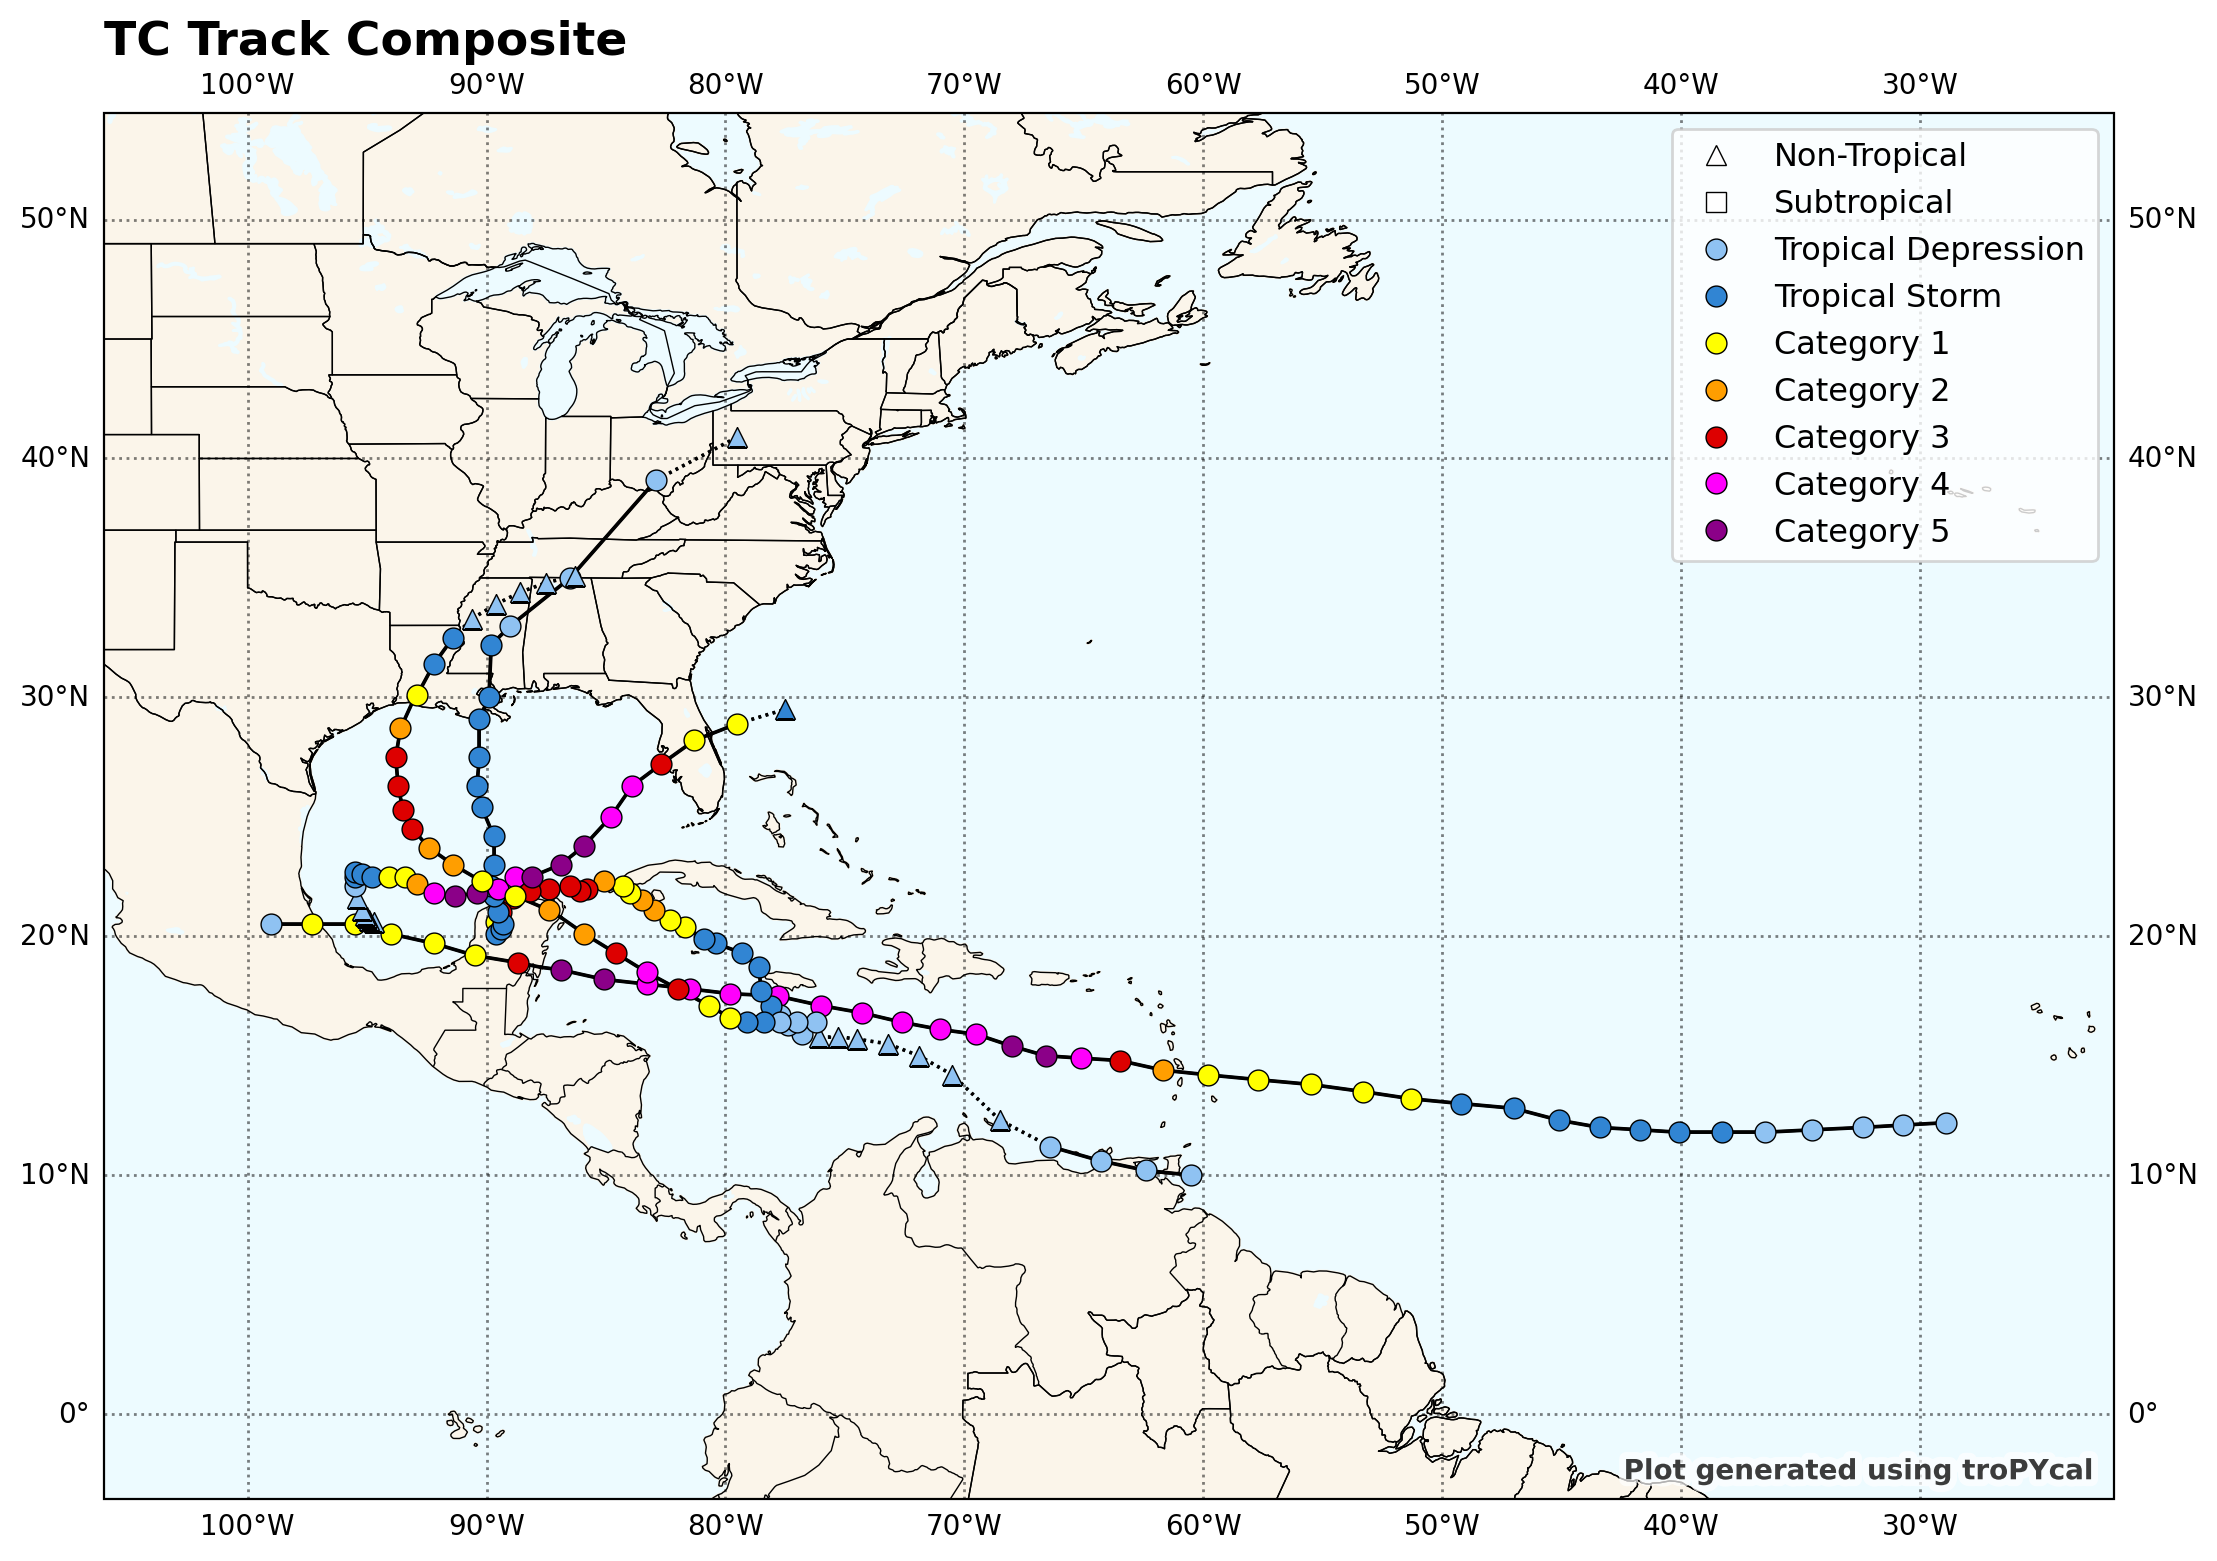

In [194]:
campeche_domain = {
    'north': 21.8, 
    'south': 17.8,
    'west': -92.5,   
    'east': -88.5    
}

campeche_storms = basin.filter_storms(
    storm=None,  # Search through all storms 
    year_range=(1999, 2024),  # Specify year range
    date_range=None,  # Include all dates within years
    thresh=thresh,  # Apply wind threshold 
    domain=campeche_domain,  # Gulf of Mexico domain
    interpolate_data=False,  # Keep original 6-hourly data
    return_keys=True  # Return  keys
)

basin.plot_storms(campeche_storms)

# Frequency
totalCampeche = len(campeche_storms)
dataFrame['Frequency'] = dataFrame['Frequency'].astype(float)
dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Frequency'] = totalCampeche

# Intensity - maximum wind speed (vmax) and minimum pressure (mslp) 
total_vmax = 0
total_mslp = 0
storm_count = 0

# Motion Vectors - represents speed and direction of storm's movement
speeds = []
directions = []
durations = []  # Initialize durations for Campeche storms

# Loops through each storm to find average vmax & mslp
for storm_key in campeche_storms:
    storm = basin.get_storm(storm_key)

    # Intensity
    max_wind = max(storm.dict['vmax'])  # Max wind speed (vmax) of the storm
    min_pressure = min([p for p in storm.dict['mslp'] if p is not None])  # Min pressure (mslp) of the storm
    
    # Update counters
    total_vmax += max_wind
    total_mslp += min_pressure
    storm_count += 1

# Calculate intensity averages
avg_vmax = total_vmax / storm_count
avg_mslp = total_mslp / storm_count

# Motion Vectors and Duration for each storm
for storm_key in campeche_storms:
    storm = basin.get_storm(storm_key)

    for i in range(1, len(storm.dict['lat'])):
        lat1, lon1 = storm.dict['lat'][i - 1], storm.dict['lon'][i - 1]
        lat2, lon2 = storm.dict['lat'][i], storm.dict['lon'][i]
        
        # Calculate distance
        distance = geodesic((lat1, lon1), (lat2, lon2)).nautical
        
        # Calculate time difference
        time_diff = (storm.dict['time'][i] - storm.dict['time'][i - 1]).total_seconds() / 3600.0  # in hours
        
        # Calculate speed 
        if time_diff > 0:
            speed = distance / time_diff
            speeds.append(speed)
            
            # Calculate direction
            direction = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1))
            directions.append(direction)

    # Duration
    start_time = storm.dict['time'][0]
    end_time = storm.dict['time'][-1]
    duration_hours = (end_time - start_time).total_seconds() / 3600.0
    durations.append(duration_hours)
    
# Calculate average speed, direction, and duration
avg_speed = np.mean(speeds) if speeds else 0
avg_direction = np.mean(directions) if directions else 0

avg_duration_hours = np.mean(durations) if durations else 0
avg_duration_days = avg_duration_hours / 24  # Convert to days

# Store results in the dataFrame for Campeche
dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Avg Vmax'] = avg_vmax
dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Avg Mslp'] = avg_mslp

dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Avg Speed'] = avg_speed
dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Avg Direction'] = avg_direction

dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Avg Duration (hours)'] = avg_duration_hours
dataFrame.loc[dataFrame['City Name'] == 'Campeche', 'Avg Duration (days)'] = avg_duration_days

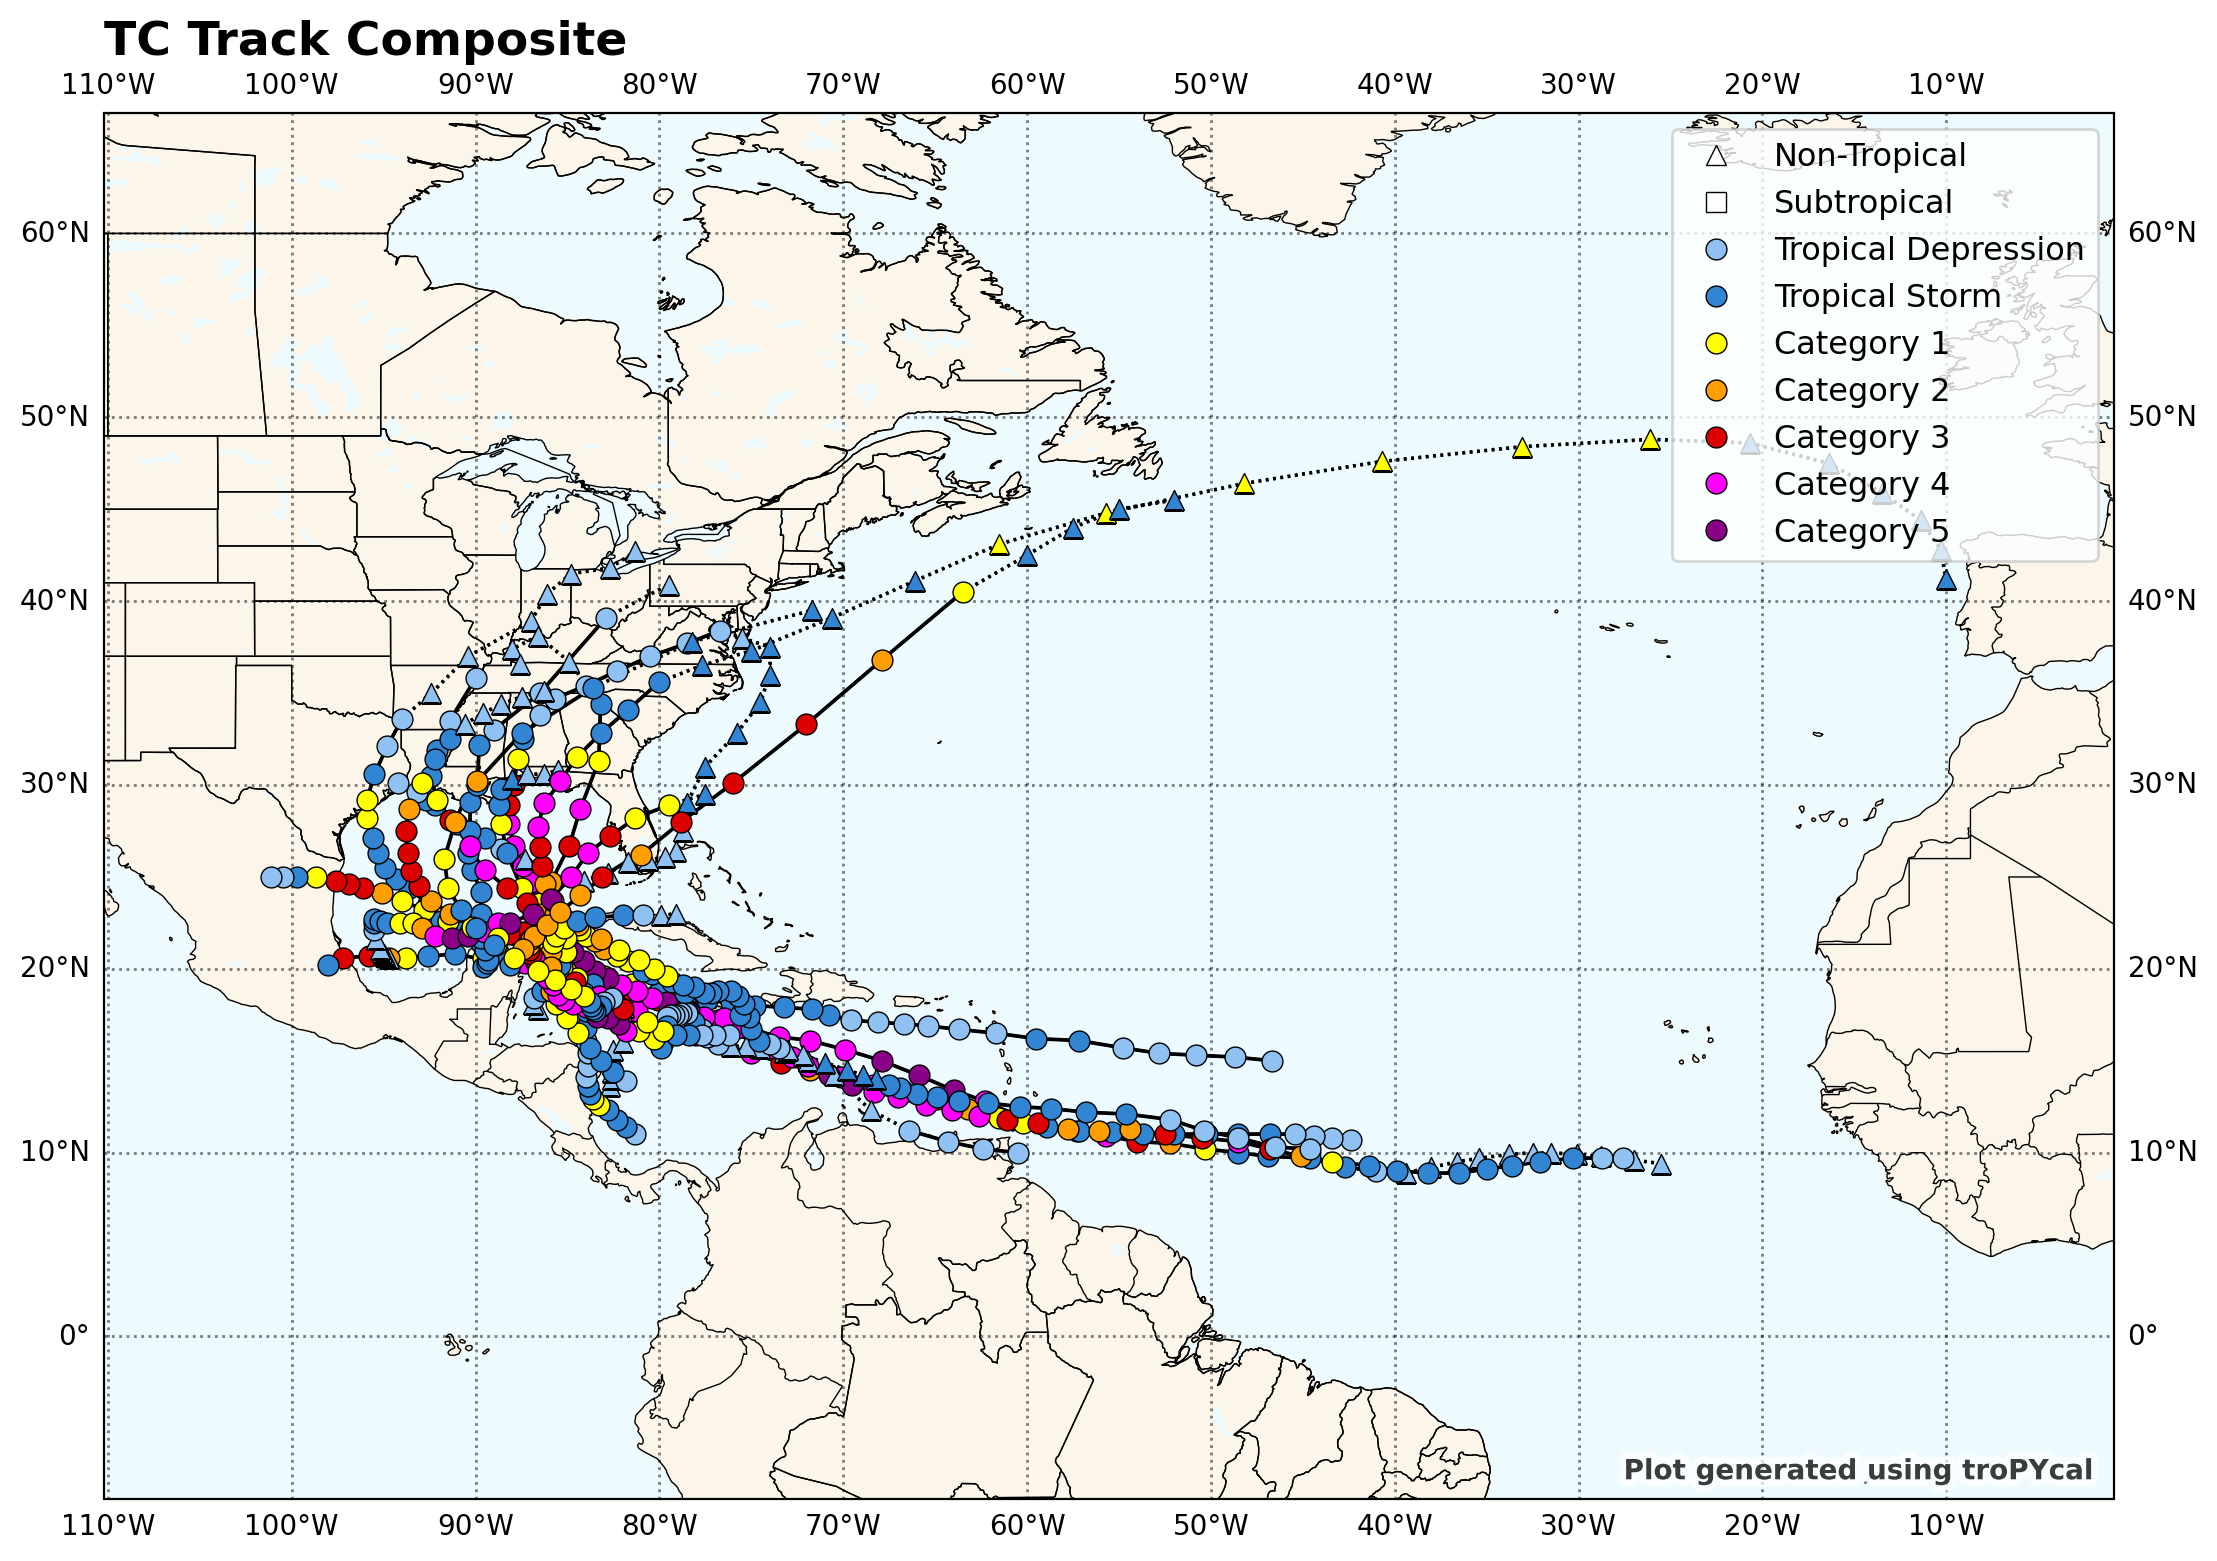

In [195]:
cancun_domain = {
    'north': 23.2, 
    'south': 19.2,
    'west': -88.9,   
    'east': -84.9    
}

cancun_storms = basin.filter_storms(
    storm=None,  # Search through all storms 
    year_range=(1999, 2024),  # Specify year range
    date_range=None,  # Include all dates within years
    thresh=thresh,  # Apply wind threshold 
    domain=cancun_domain,  # Gulf of Mexico domain
    interpolate_data=False,  # Keep original 6-hourly data
    return_keys=True  # Return  keys
)

basin.plot_storms(cancun_storms)

# Frequency
totalCancun = len(cancun_storms)
dataFrame['Frequency'] = dataFrame['Frequency'].astype(float)
dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Frequency'] = totalCancun

# Intensity - maximum wind speed (vmax) and minimum pressure (mslp) 
total_vmax = 0
total_mslp = 0
storm_count = 0

# Motion Vectors - represents speed and direction of storm's movement
speeds = []
directions = []
durations = []  # Initialize durations for Cancún storms

# Loops through each storm to find average vmax & mslp
for storm_key in cancun_storms:
    storm = basin.get_storm(storm_key)

    # Intensity
    max_wind = max(storm.dict['vmax'])  # Max wind speed (vmax) of the storm
    min_pressure = min([p for p in storm.dict['mslp'] if p is not None])  # Min pressure (mslp) of the storm
    
    # Update counters
    total_vmax += max_wind
    total_mslp += min_pressure
    storm_count += 1

# Calculate intensity averages
avg_vmax = total_vmax / storm_count
avg_mslp = total_mslp / storm_count

# Motion Vectors and Duration for each storm
for storm_key in cancun_storms:
    storm = basin.get_storm(storm_key)

    for i in range(1, len(storm.dict['lat'])):
        lat1, lon1 = storm.dict['lat'][i - 1], storm.dict['lon'][i - 1]
        lat2, lon2 = storm.dict['lat'][i], storm.dict['lon'][i]
        
        # Calculate distance
        distance = geodesic((lat1, lon1), (lat2, lon2)).nautical
        
        # Calculate time difference
        time_diff = (storm.dict['time'][i] - storm.dict['time'][i - 1]).total_seconds() / 3600.0  # in hours
        
        # Calculate speed 
        if time_diff > 0:
            speed = distance / time_diff
            speeds.append(speed)
            
            # Calculate direction
            direction = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1))
            directions.append(direction)

    # Duration
    start_time = storm.dict['time'][0]
    end_time = storm.dict['time'][-1]
    duration_hours = (end_time - start_time).total_seconds() / 3600.0
    durations.append(duration_hours)
    
# Calculate average speed, direction, and duration
avg_speed = np.mean(speeds) if speeds else 0
avg_direction = np.mean(directions) if directions else 0

avg_duration_hours = np.mean(durations) if durations else 0
avg_duration_days = avg_duration_hours / 24  # Convert to days

# Store results in the dataFrame for Cancún
dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Avg Vmax'] = avg_vmax
dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Avg Mslp'] = avg_mslp

dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Avg Speed'] = avg_speed
dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Avg Direction'] = avg_direction

dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Avg Duration (hours)'] = avg_duration_hours
dataFrame.loc[dataFrame['City Name'] == 'Cancún', 'Avg Duration (days)'] = avg_duration_days

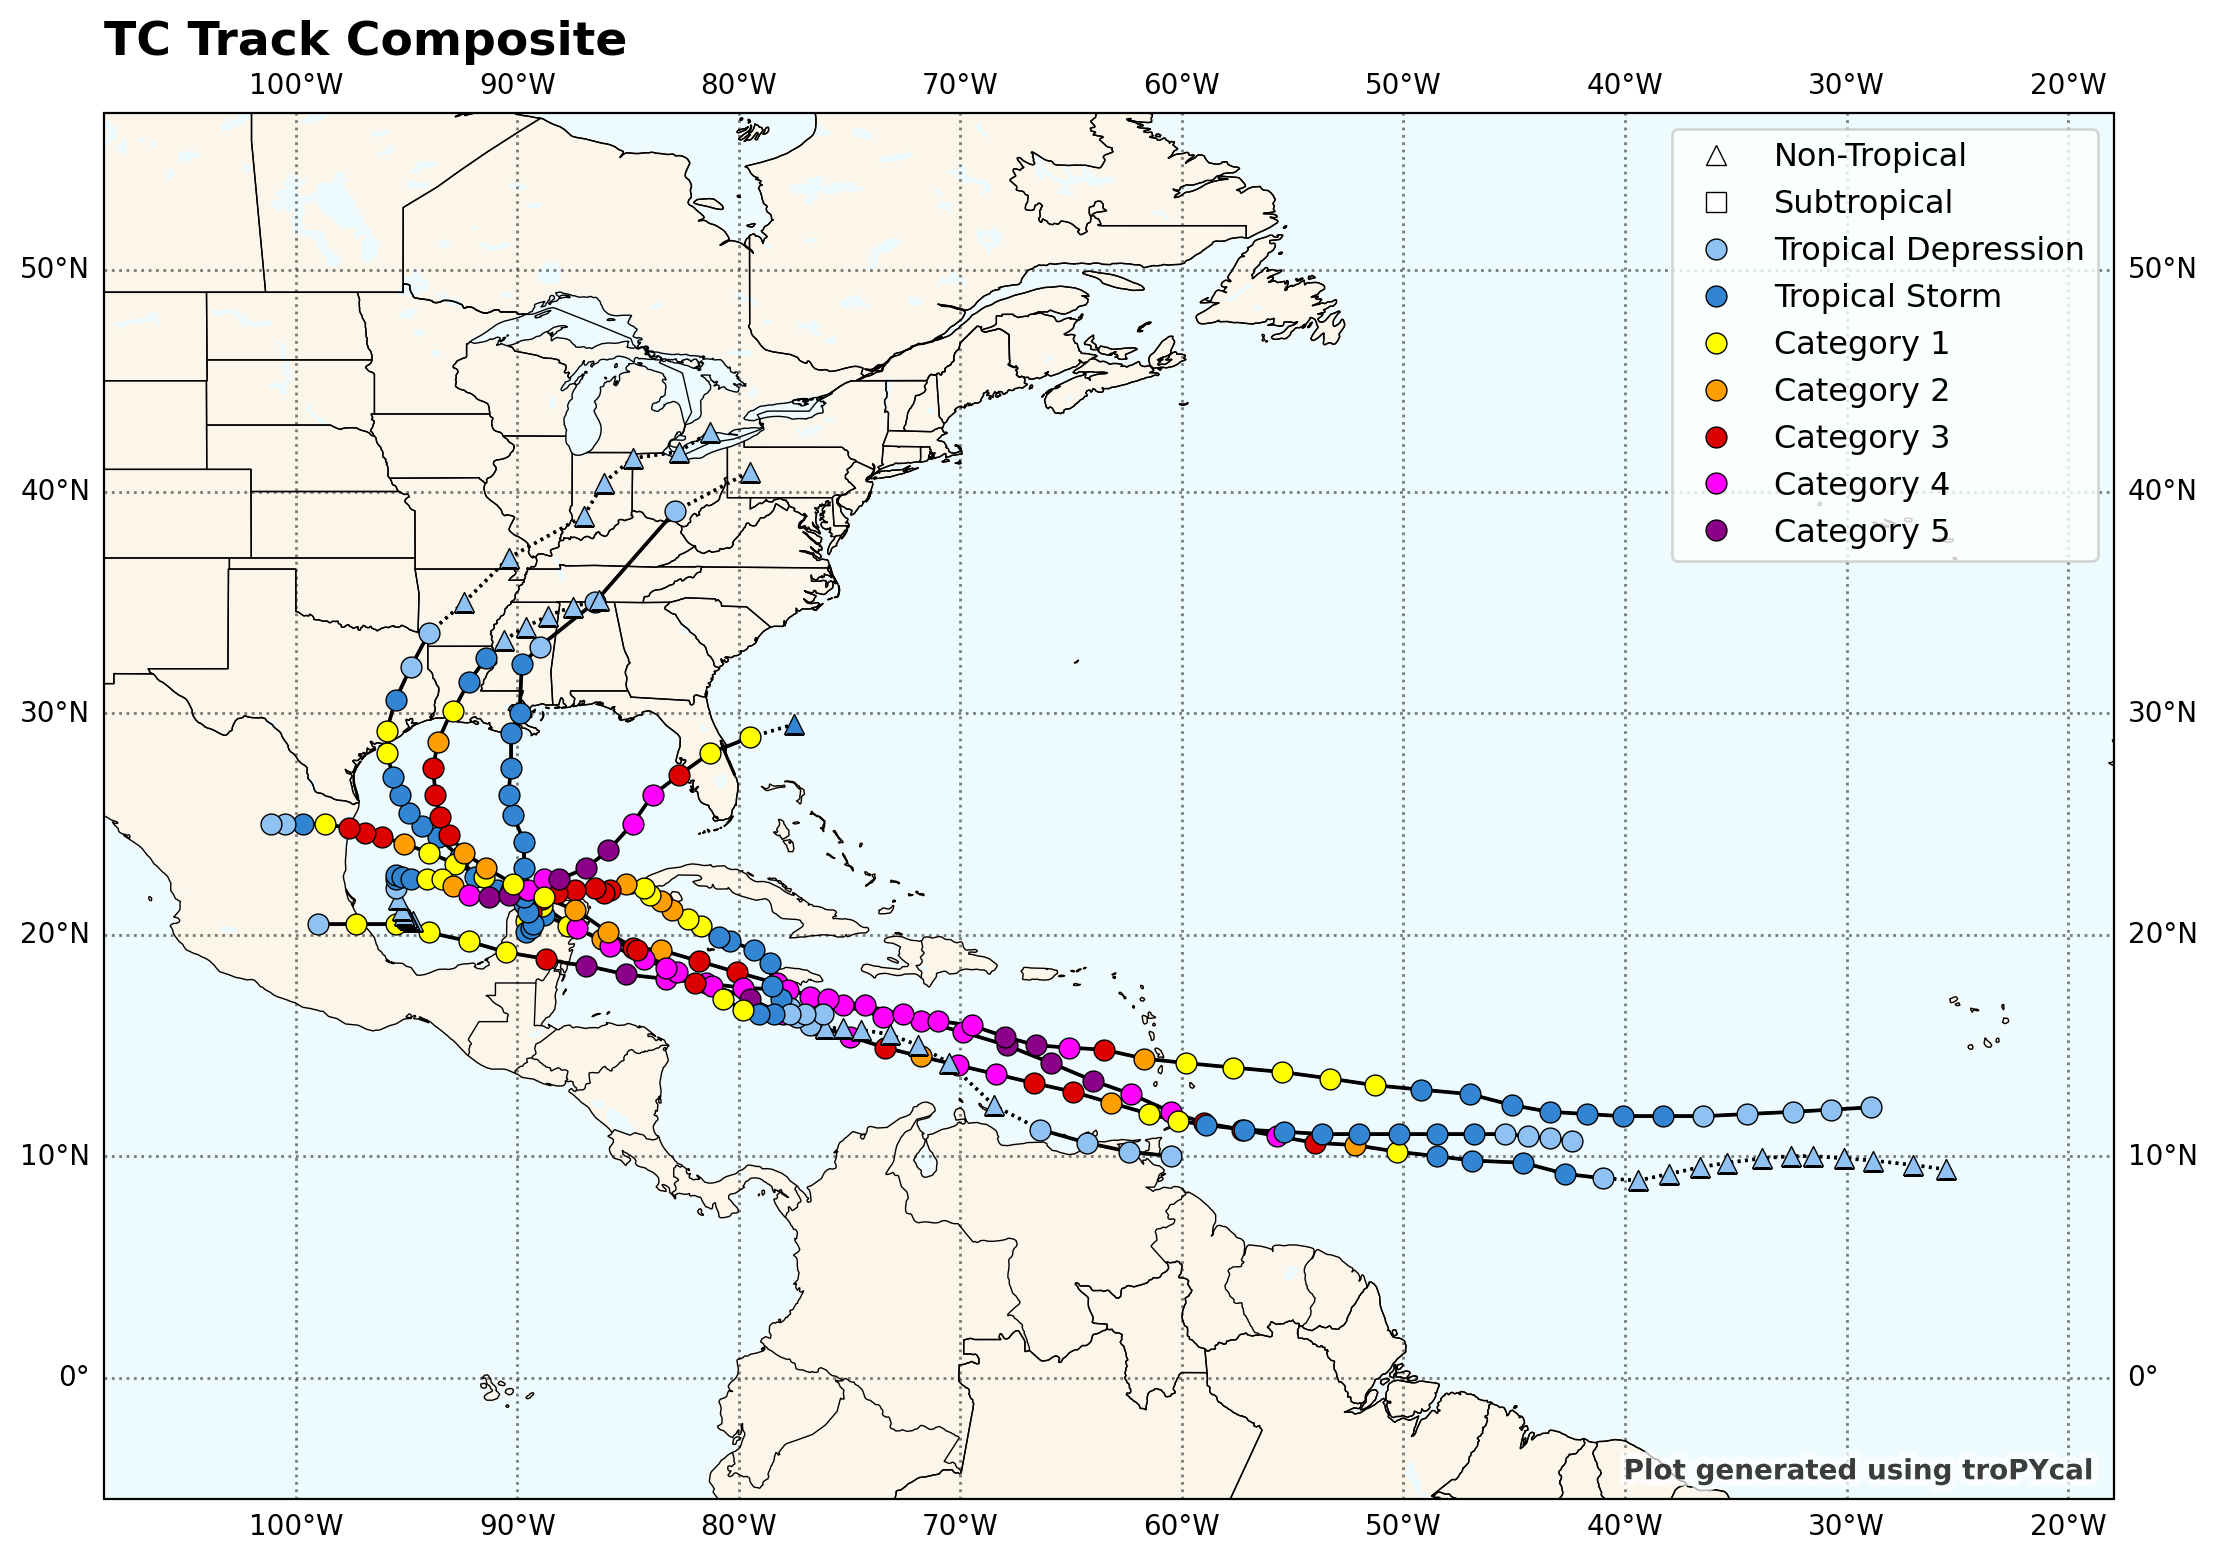

In [196]:
merida_domain = {
    'north': 22.97,
    'south': 18.97,
    'west': -91.62,
    'east': -87.62
}

merida_storms = basin.filter_storms(
    storm=None,  # Search through all storms 
    year_range=(1999, 2024),  # Specify year range
    date_range=None,  # Include all dates within years
    thresh=thresh,  # Apply wind threshold 
    domain=merida_domain,  # Gulf of Mexico domain
    interpolate_data=False,  # Keep original 6-hourly data
    return_keys=True  # Return  keys
)

basin.plot_storms(merida_storms)

# Frequency
totalMerida = len(merida_storms)
dataFrame['Frequency'] = dataFrame['Frequency'].astype(float)
dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Frequency'] = totalMerida

# Intensity - maximum wind speed (vmax) and minimum pressure (mslp) 
total_vmax = 0
total_mslp = 0
storm_count = 0

# Motion Vectors - represents speed and direction of storm's movement
speeds = []
directions = []
durations = []  # Initialize durations for Mérida storms

# Loops through each storm to find average vmax & mslp
for storm_key in merida_storms:
    storm = basin.get_storm(storm_key)

    # Intensity
    max_wind = max(storm.dict['vmax'])  # Max wind speed (vmax) of the storm
    min_pressure = min([p for p in storm.dict['mslp'] if p is not None])  # Min pressure (mslp) of the storm
    
    # Update counters
    total_vmax += max_wind
    total_mslp += min_pressure
    storm_count += 1

# Calculate intensity averages
avg_vmax = total_vmax / storm_count
avg_mslp = total_mslp / storm_count

# Motion Vectors and Duration for each storm
for storm_key in merida_storms:
    storm = basin.get_storm(storm_key)

    for i in range(1, len(storm.dict['lat'])):
        lat1, lon1 = storm.dict['lat'][i - 1], storm.dict['lon'][i - 1]
        lat2, lon2 = storm.dict['lat'][i], storm.dict['lon'][i]
        
        # Calculate distance
        distance = geodesic((lat1, lon1), (lat2, lon2)).nautical
        
        # Calculate time difference
        time_diff = (storm.dict['time'][i] - storm.dict['time'][i - 1]).total_seconds() / 3600.0  # in hours
        
        # Calculate speed 
        if time_diff > 0:
            speed = distance / time_diff
            speeds.append(speed)
            
            # Calculate direction
            direction = np.degrees(np.arctan2(lon2 - lon1, lat2 - lat1))
            directions.append(direction)

    # Duration
    start_time = storm.dict['time'][0]
    end_time = storm.dict['time'][-1]
    duration_hours = (end_time - start_time).total_seconds() / 3600.0
    durations.append(duration_hours)
    
# Calculate average speed, direction, and duration
avg_speed = np.mean(speeds) if speeds else 0
avg_direction = np.mean(directions) if directions else 0

avg_duration_hours = np.mean(durations) if durations else 0
avg_duration_days = avg_duration_hours / 24  # Convert to days

# Store results in the dataFrame for Mérida
dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Avg Vmax'] = avg_vmax
dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Avg Mslp'] = avg_mslp

dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Avg Speed'] = avg_speed
dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Avg Direction'] = avg_direction

dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Avg Duration (hours)'] = avg_duration_hours
dataFrame.loc[dataFrame['City Name'] == 'Mérida', 'Avg Duration (days)'] = avg_duration_days

Frequency vs Avg Vmax (Maximum Wind Speed)
Frequency shows how often hurricanes have impacted a city and Avg Vmax indicates the typical intensity of those storms. 
Together this shows how frequenctly a city experiences high-intesity storms.

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

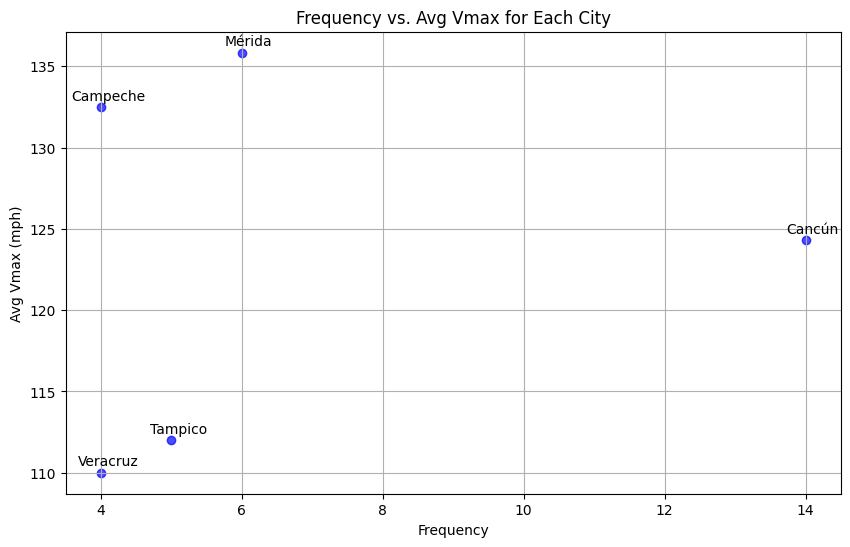

In [198]:
#scatter plot with frequency vs avg max
plt.figure(figsize=(10, 6))
plt.scatter(dataFrame['Frequency'], dataFrame['Avg Vmax'], c='blue', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Avg Vmax (mph)')
plt.title('Frequency vs. Avg Vmax for Each City')
plt.grid(True)

# Annotate each point with city names
for i, city in enumerate(dataFrame['City Name']):
    plt.annotate(city, (dataFrame['Frequency'][i], dataFrame['Avg Vmax'][i]), 
                 textcoords="offset points", xytext=(5,5), ha='center')

plt.show()

III. Risk-Profile Analysis

A. Research and identify potential natural factors influencing hurricane activity.


Factor: Atlantic Multidecadal Oscillation

Atlantic Multidecadal Oscillation is a long-term pattern of warm and cool phases in North Atlantic sea surface temperatures, each lasting 20-40 years. During warm phases, sea temperatures are higher, which tends to increase hurrivane activity in the Atlantic. In cool phases, sea temperatures drop, and hurricane activity often decreases. It also influences rainfall patterns and temperature in surrounding regions like the eastern US, and Carribean. Studying Atlantic Multidecadal Oscillation to better understand and predict changes in hurricane seasond and regional climate trends.

https://www.aoml.noaa.gov/ocd/ocdweb/ESR_GOMIEA/amo.html

https://www.worldclimateservice.com/2021/10/11/atlantic-multi-decadal-oscillation/

The AMO has a significant impact onf the Gulf of Mexico region, especially during its warm phase where sea surface temperatures are warmer than average in the North Atlantic. 

Warm AMO phases create good conditions for hurricane development. Warm waters fuel stronger storms, leading to more frequent and intense hurricanes in the Atlantic, Caribeean, and Gulf of Mexico. The Gulf region often sees an increase in both the number and strength of hurricanes which can result in hard landfalls along Gulf Coast states.
Warm AMO phases are also associated with increased rainfall as warmer waters allow for greater evaporation and moisture content in the atmosphere. This can lead to heave rainfall which increases the risk of flooding.
More frequent and powerfull hurricanes result in higher economic costs due to damage to infrastructure, homes, and businesses. It can also disrupt ecosystems, impacting wetlands and widlife habitats which are sensitive to changes in temperature.

Overall -- AMO's warm and cool phases have broad impacts on the Gulg of Mexico with the warm phase specifically linked to hightened hurricane activity which can lead to severe economic and environmental consequences. It plays a key role in weather extremes and climate patterns, influenceing everything from hurricane seasons to rainfall levels in affected regions.

https://psl.noaa.gov/data/timeseries/AMO/

The AMO factor only contains data up until the beginning of 2023.
I used ChatGPT to convert the data into a CSV file.

In [199]:
AMO = pd.read_csv(r"C:\Users\b1ane\iCloudDrive\Classes\(3337) Data Science I\Tasks\Group Task 3\amo.csv")

In [200]:
# Condense data to the last 25 years
AMO_new = AMO[AMO['Year'].between(1999, 2024)]
AMO_new.head()

Year  January  February  March  April    May   June   July  August  \
51  1999    0.057     0.061  0.065  0.068  0.070  0.073  0.077   0.081   
52  2000    0.094     0.095  0.098  0.100  0.102  0.103  0.103   0.104   
53  2001    0.109     0.110  0.111  0.113  0.115  0.119  0.123   0.127   
54  2002    0.142     0.144  0.146  0.147  0.148  0.148  0.149   0.149   
55  2003    0.150     0.150  0.149  0.146  0.145  0.144  0.142   0.139   

    September  October  November  December  
51      0.085    0.088     0.091     0.092  
52      0.106    0.108     0.108     0.109  
53      0.130    0.133     0.136     0.139  
54      0.150    0.150     0.150     0.151  
55      0.137    0.134     0.131     0.129

In [201]:
# No data available for the more recent years - handle missing data 
AMO_new.replace(-99.99, np.nan, inplace=True)
AMO_new.tail()

Year  January  February  March  April  May  June  July  August  September  \
71  2019      NaN       NaN    NaN    NaN  NaN   NaN   NaN     NaN        NaN   
72  2020      NaN       NaN    NaN    NaN  NaN   NaN   NaN     NaN        NaN   
73  2021      NaN       NaN    NaN    NaN  NaN   NaN   NaN     NaN        NaN   
74  2022      NaN       NaN    NaN    NaN  NaN   NaN   NaN     NaN        NaN   
75  2023      NaN       NaN    NaN    NaN  NaN   NaN   NaN     NaN        NaN   

    October  November  December  
71      NaN       NaN       NaN  
72      NaN       NaN       NaN  
73      NaN       NaN       NaN  
74      NaN       NaN       NaN  
75      NaN       NaN       NaN

In [202]:
#Fill in Frequency for the rest of the cities 
dataFrame.loc[dataFrame['City Name'] == 'New Orleans', 'Frequency'] = 16
dataFrame.loc[dataFrame['City Name'] == 'Houston', 'Frequency'] = 8
dataFrame.loc[dataFrame['City Name'] == 'Tampa', 'Frequency'] = 15
dataFrame.loc[dataFrame['City Name'] == 'Miami', 'Frequency'] = 10
dataFrame.loc[dataFrame['City Name'] == 'Corpus Christi', 'Frequency'] = 12
dataFrame.loc[dataFrame['City Name'] == 'Pensacola', 'Frequency'] = 6
dataFrame.loc[dataFrame['City Name'] == 'Mobile', 'Frequency'] = 7
dataFrame.loc[dataFrame['City Name'] == 'Galveston', 'Frequency'] = 8
dataFrame.loc[dataFrame['City Name'] == 'Biloxi', 'Frequency'] = 9
dataFrame.loc[dataFrame['City Name'] == 'Key West', 'Frequency'] = 8
dataFrame.loc[dataFrame['City Name'] == 'Varadero', 'Frequency'] = 27
dataFrame.loc[dataFrame['City Name'] == 'Cienfuegos', 'Frequency'] = 23
dataFrame.loc[dataFrame['City Name'] == 'George Town', 'Frequency'] = 10
dataFrame.loc[dataFrame['City Name'] == 'Nassau', 'Frequency'] = 10

In [203]:
dataFrame.head()

City Name Country  Latitude  Longitude  Frequency  Avg Vmax  Avg Mslp  \
0     New Orleans     USA   29.9511   -90.0715       16.0       NaN       NaN   
1         Houston     USA   29.7604   -95.3698        8.0       NaN       NaN   
2           Tampa     USA   27.9506   -82.4572       15.0       NaN       NaN   
3           Miami     USA   25.7617   -80.1918       10.0       NaN       NaN   
4  Corpus Christi     USA   27.8006   -97.3964       12.0       NaN       NaN   

   Avg Speed  Avg Direction  Avg Duration (hours)  Avg Duration (days)  
0        NaN            NaN                   NaN                  NaN  
1        NaN            NaN                   NaN                  NaN  
2        NaN            NaN                   NaN                  NaN  
3        NaN            NaN                   NaN                  NaN  
4        NaN            NaN                   NaN                  NaN

In [204]:
#Get average AMO for the past 25 years 
#Only yearly data available, because it's based on SST variations across a large portion of the North Atlantic
#It's a long term measure of temperature patterns
AMO_new['AMO_Yearly_Avg'] = AMO_new[['January', 'February', 'March', 'April', 'May', 'June', 
                              'July', 'August', 'September', 'October', 'November', 'December']].mean(axis=1)
AMO_yearly = AMO_new[['Year', 'AMO_Yearly_Avg']]
AMO_yearly.head()

Year  AMO_Yearly_Avg
51  1999        0.075667
52  2000        0.102500
53  2001        0.122083
54  2002        0.147833
55  2003        0.141333

In [205]:
AMO_overall_avg =  AMO_yearly['AMO_Yearly_Avg'].mean()
print(AMO_overall_avg)

0.14260416666666664
